In [1]:
import numpy as np 
import torch

# floody 
from floody import data as D

In [2]:
# causalflow 
from causalflow import causalflow

In [3]:
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
cuda = torch.cuda.is_available()
device = ("cuda:0" if cuda else "cpu")

# training/testing data 

In [5]:
fema = D.FEMA()

In [6]:
# load test data
_, XY_treated = fema.prepare_train_test('treated', split=0.9, seed=42)
_, XY_control = fema.prepare_train_test('control', split=0.9, seed=42)

In [7]:
# reduce dynamic range of data
XY_treated[:,0] = np.log10(XY_treated[:,0])
XY_treated[:,3] = np.log10(XY_treated[:,3])
XY_treated[:,4] = np.log10(XY_treated[:,4])

# reduce dynamic range of data
XY_control[:,0] = np.log10(XY_control[:,0])
XY_control[:,3] = np.log10(XY_control[:,3])
XY_control[:,4] = np.log10(XY_control[:,4])

# `CausalFlow`

In [8]:
# declare Scenario A CausalFlow
Cflow = causalflow.CausalFlowA(device=device)

In [9]:
flows = Cflow._load_flows_optuna('flow.treated', '/scratch/gpfs/chhahn/noah/floody/flow/')

alpha_lin = np.linspace(0., 1., 20)
ecps_lin_t = []
for ii in range(11):
    alpha_t, ecp_t = Cflow._validate(flows, XY_treated[:,1:], XY_treated[:,0][:,None], Nsample=10000, verbose=False)
    ecps_lin_t.append(np.interp(alpha_lin, alpha_t, ecp_t))

flows = Cflow._load_flows_optuna('flow.control', '/scratch/gpfs/chhahn/noah/floody/flow/')
ecps_lin_c = [] 
for ii in range(11):
    alpha_c, ecp_c = Cflow._validate(flows, XY_control[:,1:], XY_control[:,0][:,None], Nsample=10000, verbose=False)
    ecps_lin_c.append(np.interp(alpha_lin, alpha_c, ecp_c))

NameError: name 'ecps_lin_c' is not defined

In [11]:
flows = Cflow._load_flows_optuna('flow.control', '/scratch/gpfs/chhahn/noah/floody/flow/')
ecps_lin_c = []
for ii in range(11):
    alpha_c, ecp_c = Cflow._validate(flows, XY_control[:,1:], XY_control[:,0][:,None], Nsample=10000, verbose=False)
    ecps_lin_c.append(np.interp(alpha_lin, alpha_c, ecp_c))

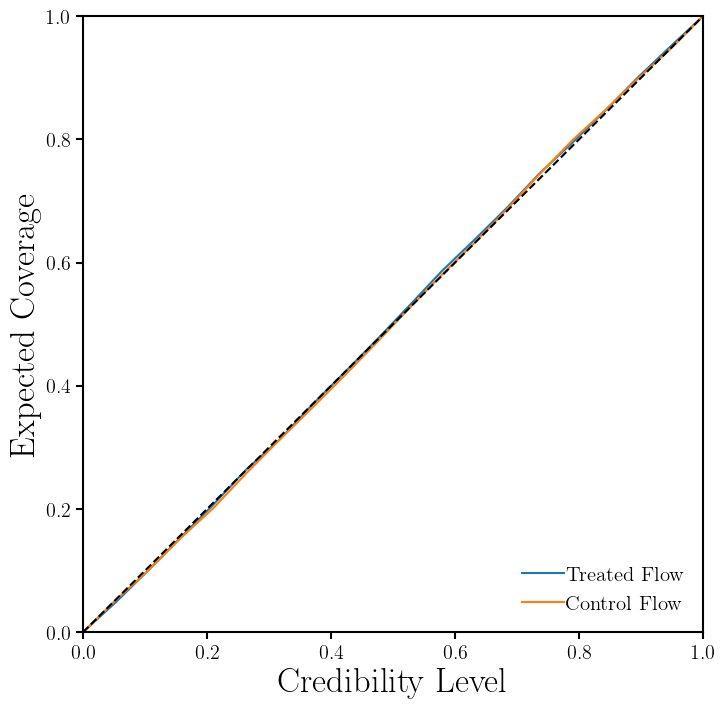

In [12]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.plot(alpha_lin, np.median(np.array(ecps_lin_t), axis=0), label='Treated Flow')
ax.plot(alpha_lin, np.median(np.array(ecps_lin_c), axis=0), label='Control Flow')
ax.plot([0, 1], [0, 1], ls="--", color="k")

ax.legend(loc='lower right', handletextpad=0.1, fontsize=15)
ax.set_ylabel("Expected Coverage", fontsize=25)
ax.set_ylim(0., 1.)
ax.set_xlabel("Credibility Level", fontsize=25)
ax.set_xlim(0., 1.)
fig.savefig('flow_valid.pdf', bbox_inches='tight')